# Classical ON/OFF Analysis: Exclusion regions and generating RBM maps
We've seen how to run a standard ON/OFF analysis from scratch for the most simple case. But what if we have a more complex region that requires excluding other sources, or bright stars? This tutorial will walk through how to define exclusion regions and apply them during the data preparation phase. It will also show how to use those exclusions to generate an RBM significance map.

In [1]:
# Import the standard moduals
import gammalib
import ctools
import cscripts

# Import matplotlib for visualization
%matplotlib inline
import matplotlib.pyplot as plt

## Defining the input exclusion map
The primary input for defining the regions for exclusions is a skymap. If a bin in the skymap has a non-zero value then any events that fall in that bin will be excluded from analysis.

In addition to the Crab itself, we'll use the three typical stars in the field of view:
* Zeta Tauri (84.4112, 21.1426)
* O Tauri (81.9087, 21.937)
* 121 Tauri (83.863, 24.0396)

**Note:** ncluding the Crab in our exclusion map has no effect on our fit (`ctlike`) since the source region is excluded by default. However, as we'll see later, it does have an impact when we try to generate an RBM map.

In [2]:
# Define the crab position
srcname = 'Crab'
ra  = 83.633
dec = 22.0145

# Define exclusion regions (ra, dec, radius)
regions = gammalib.GSkyRegions()
regions.append(gammalib.GSkyRegionCircle(ra, dec, 0.4))  # Crab Nebula
regions.append(gammalib.GSkyRegionCircle(84.4112, 21.1426, 0.3))  # Zeta Tauri
regions.append(gammalib.GSkyRegionCircle(81.9087, 21.9370, 0.3))  # O Tauri
regions.append(gammalib.GSkyRegionCircle(83.8630, 24.0396, 0.3))  # 121 Tauri
regions.save('resources/exclmap.reg')

# Create a skymap
binsz = 0.02
exclmap = gammalib.GSkyMap('CAR', 'CEL', ra, dec, -binsz, binsz, 400, 400)

# Set pixels to be excluded
for indx in range(exclmap.npix()):
    dir = exclmap.inx2dir(indx)      # Get the position of the bin
    if regions.contains(dir):        # Check if the bin contains this exclusion
        exclmap[indx] += 1.0

# Save the exclusion map
exclmap_file = 'resources/exclmap.fits'
exclmap.save(exclmap_file, True)

Visualizing the the exclusion map:

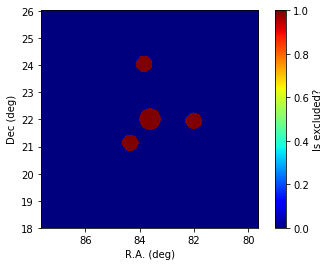

In [3]:
#module used to stretch the color palette
import matplotlib.colors as colors

ax = plt.subplot()
plt.imshow(exclmap.array(),origin='lower',
            extent=[ra+binsz*200,ra-binsz*200,dec-binsz*200,dec+binsz*200],
            cmap=plt.get_cmap('jet')) # square root scale 
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Is excluded?')

## Running the analysis
As we did before, the first step is to prepare the data for analysis using `csphagen`. This time, however, we will also pass in the exclusion map 

In [4]:
# Define the observation file generated in the previous tutorials
obsfile  = 'resources/obs_selected.xml'

# Setup the csphagen script
phagen = cscripts.csphagen()
phagen['inobs']         = obsfile       
phagen['inexclusion']   = exclmap_file      # The name of the exclusion map
phagen['outobs']        = 'resources/obs_onoff_unstacked_excl.xml'
phagen['outmodel']      = 'resources/onoff_unstacked_excl_model.xml'
phagen['prefix']        = 'resources/onoff_unstacked_excl'
phagen['inmodel']       = 'NONE'            # assume that the source is pointlike
phagen['ebinalg']       = 'LOG'             # Method for defining energy bins
phagen['emin']          = 0.16              # Minimum energy (TeV)
phagen['emax']          = 30.0              # Maximum energy (TeV)
phagen['enumbins']      = 20                # Number of energy bins
phagen['coordsys']      = 'CEL'             # Coord. system for analysis
phagen['ra']            = 83.633            # RA of ON region center
phagen['dec']           = 22.0145           # Dec of ON region center
phagen['rad']           = 0.1               # Radius of ON region (degrees)
phagen['bkgmethod']     = 'REFLECTED'       # Reflected region analysis
phagen['use_model_bkg'] = False             # No model for the background
phagen['maxoffset']     = 1.6               # Maximum source offset for data file to be considered
phagen['stack']         = False             # Dont stack the data

phagen.execute()

In [5]:
# Rename the source model
phagen.obs().models()['Dummy'].name(srcname)
phagen.obs().models()[srcname].tscalc(True)

# Make the Crab a log-parabola model
pref  = 3.4e-17
index = -2.4
pivot = gammalib.GEnergy(1.0, 'TeV')
curv  = -0.15
spectrum = gammalib.GModelSpectralLogParabola(pref, index, pivot, curv)

# Set the Crab spectrum
phagen.obs().models()[srcname].spectral(spectrum)

In [6]:
# Likelihood
like = ctools.ctlike(phagen.obs())
like['outmodel'] = 'resources/crab_onoff_unstacked_excl.xml'
like.execute()

# Print the results of the fit
print(like.opt())
print(like.obs().models())

=== GOptimizerLM ===
 Optimized function value ..: 20.136
 Absolute precision ........: 0.005
 Acceptable value decrease .: 2
 Optimization status .......: converged
 Number of parameters ......: 7
 Number of free parameters .: 3
 Number of iterations ......: 3
 Lambda ....................: 1e-06
=== GModels ===
 Number of models ..........: 1
 Number of parameters ......: 7
=== GModelSky ===
 Name ......................: Crab
 Instruments ...............: all
 Test Statistic ............: 910.394278399891
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "LogParabola" * "Constant"
 Number of parameters ......: 7
 Number of spatial par's ...: 2
  RA .......................: 83.633 deg (fixed,scale=1)
  DEC ......................: 22.0145 deg (fixed,scale=1)
 Number of spectral par's ..: 4
  Prefactor ................: 3.84153236833872e-17 +/- 3.7037989662069e-18 [0,infty[ ph/cm2/s/MeV (free,scale=3.4e-17,gradient)


## RBM significance map
Let's try to generate a ring-background residual-counts map from the data. Note that we're only using two observations, so it will probably look pretty terrible.

To generate the map we will use `ctskymap` again, but this time we'll set the background subtraction method to 'RING'

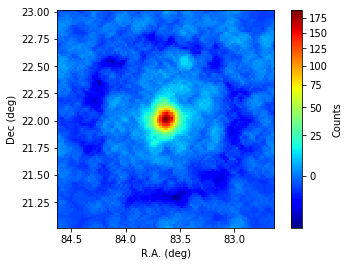

In [7]:
# Run ctskymap
skymap = ctools.ctskymap()
skymap['inobs'] = obsfile
skymap['emin']   = 0.16
skymap['emax']   = 30.0
skymap['nxpix']    = 100
skymap['nypix']    = 100
skymap['binsz']    = 0.02
skymap['coordsys'] = 'CEL'
skymap['proj']     = 'CAR'   # Cartesian projection
skymap['xref']     = ra
skymap['yref']     = dec
skymap['bkgsubtract'] = 'RING'
skymap['roiradius']   = 0.065
skymap['inradius']    = 0.6
skymap['outradius']   = 0.8

skymap.run()

# Visualize the map
ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
            extent=[ra+binsz*50,ra-binsz*50,dec-binsz*50,dec+binsz*50],
            norm=colors.PowerNorm(gamma=0.5),
            cmap=plt.get_cmap('jet')) # square root scale 
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

As expected, there's a deficit ring around the Crab. Why? Because we didn't exclude the Crab! So let's apply the exclusion map that we defined above.

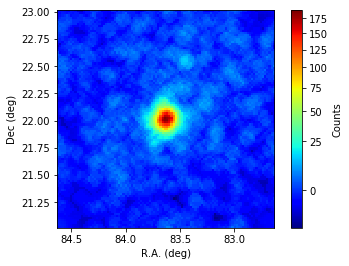

In [8]:
# Clear the old map and define exclusions
skymap.exclusion_map(gammalib.GSkyRegionMap(exclmap))
skymap.run()

# Visualize the map
ax = plt.subplot()
plt.imshow(skymap.skymap().array(),origin='lower',
            extent=[ra+binsz*50,ra-binsz*50,dec-binsz*50,dec+binsz*50],
            norm=colors.PowerNorm(gamma=0.5),
            cmap=plt.get_cmap('jet')) # square root scale 
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec (deg)')
cbar = plt.colorbar()
cbar.set_label('Counts')

That looks much better! 

**IMPORTANT NOTE:** You should keep in mind that this is not a TRUE RBM map. There is no accounting for the changing background sensitivity, so the difference in the area between the ring and source region is the only correction applied to the estimate of OFF counts in the ON region. It is possible to add a background IRF column to the data, which would then be used for weighting pixels in the OFF region. However, the observations we're using don't have that information, so it is ignored when generating the above maps.